## Neighbour Cell Definition using Classification

In [1]:
import numpy as np
import pandas as pd
from numpy import pi, sin, cos
import plotly.graph_objs as go
import plotly.express as px
import math
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

### Creating folds for training data

In [2]:
# Read training data
df = pd.read_excel("Neighbour_train.xlsx")#, dtype={"Sector_ID": str})

# we create a new column called kfold and fill it with -1
df["kfold"] = -1

# the next step is to randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

# fetch labels
y = df.Target.values

# initiate the kfold class from model_selection module
# as shown in below bar chart the number of labels is not equal, therefore StratifiedKFold cross validation is used
kf = model_selection.StratifiedKFold(n_splits=5)

# fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

# save the new csv with kfold column
df.to_excel("Neighbour_train_folds.xlsx", index=False)

In [3]:
df.head()

,Relation,Source,Neighbour,Latitude_S,Longitude_S,Latitude_N,Longitude_N,TA_S,TA_N,Azimuth_Diff,Latitude_Diff,Longitude_Diff,Distance(m),Overlap_Ratio,Sector_Type_S,Sector_Type_N,Target,kfold
0,"(QM0210C,QM0291A)",QM0210C,QM0291A,34.81594,50.71731,34.670920,50.825600,27500,1375,180,0.145020,-0.108290,18898.549183,0.000000,0,3,0,0
1,"(QM0005B,QM0149C)",QM0005B,QM0149C,34.65963,50.69642,34.659150,50.882310,31075,825,10,0.000480,-0.185890,17039.656729,0.000000,0,1,0,0
2,"(QM0210B,QM0093A)",QM0210B,QM0093A,34.81594,50.71731,35.135470,50.966680,14025,31075,10,-0.319530,-0.249370,42132.373560,0.000000,0,0,0,0
3,"(QM0001B,QM0102A)",QM0001B,QM0102A,34.62224,50.90899,34.627290,50.901440,1375,1375,90,-0.005050,0.007550,890.617584,11.724262,1,1,1,0
4,"(QM0210C,QM0144C)",QM0210C,QM0144C,34.81594,50.71731,34.543564,50.278942,27500,2475,60,0.272376,0.438368,50268.001024,0.000000,0,2,0,0


In [4]:
df.columns

Index(['Relation', 'Source', 'Neighbour', 'Latitude_S', 'Longitude_S',
       'Latitude_N', 'Longitude_N', 'TA_S', 'TA_N', 'Azimuth_Diff',
       'Latitude_Diff', 'Longitude_Diff', 'Distance(m)', 'Overlap_Ratio',
       'Sector_Type_S', 'Sector_Type_N', 'Target', 'kfold'],
      dtype='object')

### Distribution of Labels

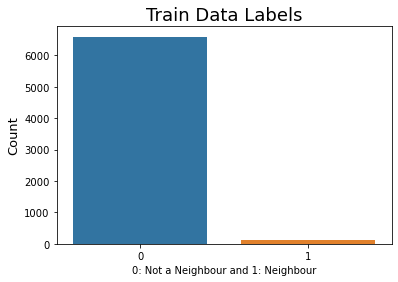

In [5]:
b = sns.countplot(x='Target', data=df)#,
                 #order=['Rural','City Capacity','City Coverage','Umbrella'])
b.set_title('Train Data Labels', fontsize=18)
b.set_ylabel("Count", fontsize=13)
b.set_xlabel("0: Not a Neighbour and 1: Neighbour");

In [6]:
# number of samples in each fold
df.kfold.value_counts()

0    1340
1    1340
2    1340
3    1340
4    1339
Name: kfold, dtype: int64

In [7]:
# number of categories in each fold
df[['kfold','Target','Relation']].groupby(by=['kfold','Target']).count()

Relation
kfold Target          
0     0           1318
      1             22
1     0           1318
      1             22
2     0           1318
      1             22
3     0           1318
      1             22
4     0           1318
      1             21

In [8]:
import xgboost as xgb
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [9]:
# load the full training data with folds
df = pd.read_excel("Neighbour_train_folds.xlsx")

### Feature Engineering

In [10]:
# making a feature list
features = [
    f for f in df.columns if f not in ('Relation', 'Source', 'Neighbour', 'Latitude_S', 'Longitude_S',
                                       'Latitude_N', 'Longitude_N', 'Target', 'kfold')
]

features

['TA_S',
 'TA_N',
 'Azimuth_Diff',
 'Latitude_Diff',
 'Longitude_Diff',
 'Distance(m)',
 'Overlap_Ratio',
 'Sector_Type_S',
 'Sector_Type_N']

### Model evaluation and selection

In [11]:
# initiating classification models
from sklearn.ensemble import GradientBoostingClassifier

models=[
    ['Linear SVM', svm.SVC(kernel='linear')],
    ['Logistic Regression', linear_model.LogisticRegression()],
    ['Random Forest', ensemble.RandomForestClassifier(n_jobs=-1)],
    ['XGBoost', xgb.XGBClassifier(n_jobs=-1,max_depth=11,n_estimators=250, verbosity = 0)], #n_jobs=-1,max_depth=11,n_estimators=250, verbosity = 0)], # **xgb_best_params
]

### Hyper-parameter Optimization

In [12]:
import optuna
from tqdm.auto import tqdm

fold = 0

df_train = df[df.kfold != fold].reset_index(drop=True)

# get validation data using folds
df_valid = df[df.kfold == fold].reset_index(drop=True)
# this is for checking accuracy for each individual label
#df_valid = df_valid.loc[df_valid['Target'] == 3]

# get training data
x_train = df_train[features].values

# get validation data
x_valid = df_valid[features].values

y_train=df_train.Target.values

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgbc = xgb.XGBClassifier(**xgb_params)
    
    #Train the model using the training sets
    xgbc.fit(x_train, y_train)
    # print(model.feature_importances_)

    #Predict the response for test dataset
    y_pred = xgbc.predict(x_valid)
    print(metrics.accuracy_score(df_valid.Target.values, y_pred))
    
    return metrics.accuracy_score(df_valid.Target.values, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)
xgb_best_params = study.best_params

[I 2022-12-17 14:30:02,895] A new study created in memory with name: no-name-d4ecb015-6988-4aaf-911c-617701c1e0f1


[14:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-17 14:30:11,880] Trial 0 finished with value: 0.9888059701492538 and parameters: {'max_depth': 5, 'learning_rate': 0.001144002226678979, 'n_estimators': 2861, 'min_child_weight': 2, 'colsample_bytree': 0.39034933143346645, 'subsample': 0.21112120298082282, 'reg_alpha': 0.029962769314771535, 'reg_lambda': 0.010012633851047665}. Best is trial 0 with value: 0.9888059701492538.


0.9888059701492538
[14:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-17 14:30:24,433] Trial 1 finished with value: 0.9835820895522388 and parameters: {'max_depth': 10, 'learning_rate': 0.00011278716690018427, 'n_estimators': 6163, 'min_child_weight': 5, 'colsample_bytree': 0.30562129750159484, 'subsample': 0.7927752688368364, 'reg_alpha': 0.2121457071300744, 'reg_lambda': 48.892132287053144}. Best is trial 0 with value: 0.9888059701492538.


0.9835820895522388
[14:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-17 14:30:42,427] Trial 2 finished with value: 0.9932835820895523 and parameters: {'max_depth': 9, 'learning_rate': 0.0007997504138680131, 'n_estimators': 4675, 'min_child_weight': 3, 'colsample_bytree': 0.6136667577377195, 'subsample': 0.8586798337613348, 'reg_alpha': 0.004836793667171623, 'reg_lambda': 0.46707896299706564}. Best is trial 2 with value: 0.9932835820895523.


0.9932835820895523
[14:30:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-17 14:31:03,066] Trial 3 finished with value: 0.9940298507462687 and parameters: {'max_depth': 10, 'learning_rate': 0.0008020502986575688, 'n_estimators': 4327, 'min_child_weight': 1, 'colsample_bytree': 0.9018518529871027, 'subsample': 0.5378058342490113, 'reg_alpha': 0.0001509590775546864, 'reg_lambda': 0.00016823496859873503}. Best is trial 3 with value: 0.9940298507462687.


0.9940298507462687
[14:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-17 14:31:06,945] Trial 4 finished with value: 0.9917910447761195 and parameters: {'max_depth': 5, 'learning_rate': 0.08583530749972239, 'n_estimators': 1717, 'min_child_weight': 8, 'colsample_bytree': 0.5498220497922023, 'subsample': 0.7838825968004846, 'reg_alpha': 0.024705691710104994, 'reg_lambda': 0.6763298014269367}. Best is trial 3 with value: 0.9940298507462687.


0.9917910447761195


### Test data prediction

In [19]:
# Evaluating the best model on test set

# load the full training data with folds
df_train = pd.read_excel("Neighbour_train_folds.xlsx")
df_test = pd.read_excel("Neighbour_test.xlsx")

y_train=df_train.Target.values

x_train = df_train[features]
x_test = df_test[features]
# n_jobs=-1,max_depth=11,n_estimators=250, verbosity = 0
best_classsifier=xgb.XGBClassifier(**xgb_best_params)
y_pred = best_classsifier.fit(x_train,y_train).predict(x_test)

### Feature importance

<AxesSubplot:>

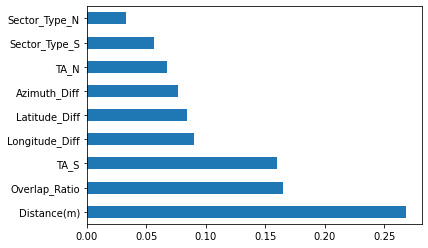

In [20]:
%matplotlib inline 
(pd.Series(best_classsifier.feature_importances_, index=features)
   .nlargest(9)
   .plot(kind='barh'))

In [22]:
result = pd.DataFrame({
        "Source": df_test["Source"],"Neighbour": df_test["Neighbour"],"TA_S": df_test["TA_S"],"TA_N": df_test["TA_N"]
        ,"Target": y_pred
    })

result = result[result['Target'] > 0]
result.to_excel('prediction_result.xlsx', index=False)
result[result['Source'] == 'QM0002A']

,Source,Neighbour,TA_S,TA_N,Target
0,QM0002A,QM0002A,1375,1375,1
1,QM0002A,QM0002B,1375,1375,1
2,QM0002A,QM0002C,1375,825,1
38,QM0002A,QM0241A,1375,1375,1
40,QM0002A,QM0223B,1375,1375,1
46,QM0002A,QM0044C,1375,825,1
53,QM0002A,QM0090B,1375,1375,1
61,QM0002A,QM0200B,1375,1925,1
109,QM0002A,QM0217C,1375,1375,1
126,QM0002A,QM0040C,1375,1375,1


In [23]:
# TA / S2S dist. ratio to be used as a new feature?